### Understanding Q-Learning in 20 Questions
Andrew Gibbs-Bravo | Mike Cluley | Software Agents INM426 

Notebook Sections: <br>
* [Define the 20 Questions Environment](#Define-Environment)
    - Create a discrete environment for 20 questions in the style of OpenAI Gym environments
* [Create Grid Q-Learning Agent, Gridsearch Hyperparameters, and Evaluate Performance](#Grid-Q-Learning-Agent)
    - Program tabular Q-Learning agent to solve 20 questions environment (includes gridsearch)
* [Train Decision Tree and Compare Performance](#Decision-Tree-Algorithm-Performance)
    - Build a decision tree model and compare performance to Q-learning model for benchmarking
* [Create Deep-Q Agent](#Deep-Q-Network)
    - Program Deep-Q Learning agent to solve 20 questions environment
    - Improvements include: implementing experience replay and also training a target network (Double Deep Q Network)
* [Create New Environment Bayesian Environment](#Bayesian-Environment-w/-Deep-Q-Agent)
    - Reformulate environment into continuous state space of probability distribution over possible animals
    - Apply similar Deep-Q agent with smaller network and slightly different code reflecting different environment

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import gym
from gym import error, spaces, utils
from gym.utils import seeding

# Package for showing update bars 
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import deque

import os
#os.chdir('C:/Users/AGB/Desktop/Data_Science_MSc/Reinforcement_Learning')
print(os.getcwd())

C:\Users\AGB\Desktop\Data_Science_MSc\Reinforcement_Learning


In [13]:
# Helper functions
def env_complexity(level):
    """Define possibles animals and possible features for environment"""
    assert 1 <= level <= 3, 'Please select a level between 1-3'
    if level == 1:
        animal = ['swan','dolphin','fruitbat','cavy']
        features = ['Aquatic','Airborne','Animal']
        
    elif level == 2:
        animal = ['swan','dolphin','fruitbat','cavy','antelope','bass','bear','rhea']
        features = ['Aquatic','Airborne','Predator','Tail','Fins','Toothed','Eggs',
                   'Domestic','Catsize','Nlegs_4','Animal']
    
    elif level == 3:
        animal = ['swan','dolphin','fruitbat','cavy','aardvark','chicken','clam','crab','gull','haddock',
                 'kiwi','ladybird','ostrich','penguin','scorpion','vulture','wasp','worm','starfish']
        
        features = ['Aquatic','Airborne','Predator','Eggs','Backbone','Nlegs_5','Animal']
        
    return animal, features

def query_tree(correct_animal, feature):
    """Returns the characteristic of the correct animal"""
    return df[feature].loc[df['Animal'] == correct_animal].item()

def posterior(correct_animal, feature, prior):
    """Calculates the posterior in the Bayesian environment"""
    likelihood = (df[feature] == query_tree(correct_animal,feature))*prior
    posterior = likelihood / np.sum(likelihood)
    return posterior.values

def make_guess(correct_animal, predicted_animal):
    """Returns whether the predicted animal matches the correct animal"""
    if correct_animal == predicted_animal:
        return 1
    else:
        return 0

def plot_performance(n_episodes, track_num_episodes, epsilon_values, total_return):
    """Plots the performance by episode. 
    Only used in simple environments with few episodes as does not take any weighted average"""
    iteration_number = range(int(n_episodes/track_num_episodes))

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    ax0.plot(iteration_number, epsilon_values)
    ax1.plot(iteration_number, total_return,'g');
    
def moving_average(a, n=3):
    """Plots moving average performance for larger numbers of episodes"""
    if isinstance(a, pd.Series):
        return plt.plot(a.rolling(n).mean())
    else:
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return plt.plot(ret[n - 1:] / n)

# Define Environment

In [14]:
# Load animal characteristic information
df = pd.read_csv('knowledge_base.csv')   # Source: https://github.com/earthtojake/20q

# Set environment complexity
animal, features = env_complexity(3)

# Select subset of dataframe based on environment complexity
df = df[features].loc[df['Animal'].isin(animal)]
df = df.join(pd.get_dummies(df['Animal']),how='outer')

action_space = list(df.drop('Animal',axis=1).columns)

random.seed(34)

In [15]:
class QuestionsGame(gym.Env):
    """Define the discrete 20 Questions game environment in the style of OpenAI Gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, correct_animal, state, win_reward, lose_reward, turn_reward):
        self.correct_animal = correct_animal
        self.state = state
        self.episode_over = 0
        self.reward = 0
        self.win_reward = win_reward
        self.lose_reward = lose_reward
        self.turn_reward = turn_reward

    def take_action(self, correct_animal, action):
        if action >= len(features)-1:
            self.state[-1] = make_guess(self.correct_animal, action_space[action])
        else:
            self.state[action] = query_tree(self.correct_animal, action_space[action])
    
    def step(self, action):
        assert 0 <= action <= len(action_space)-1, 'Please select an action from the action space'
        
        if action >= len(features)-1:
            self.state[-1] = make_guess(self.correct_animal, action_space[action])
            self.episode_over = 1
            if self.state[-1] == 1:
                self.reward = self.win_reward
            else:
                self.reward = self.lose_reward
        else:
            self.state[action] = query_tree(self.correct_animal, action_space[action])
            self.reward = self.turn_reward
        
        return self.state, self.reward, self.episode_over
    
    def reset(self):
        self.state = len(features) * [-1]
        self.reward = 0
        self.episode_over = 0
        
    def render(self, mode='human', close=False):
        print(self.state)

# Grid Q-Learning Agent

In [16]:
from sklearn.model_selection import ParameterGrid

# Index the state space so it can be easily represented in the Q-Table
feat_dict = {x:[-1,0,1] for x in features}
grid = ParameterGrid(feat_dict)
coded_states = pd.DataFrame(list(grid))[features]
n_states = len(coded_states)

def get_state_index(state):
    """Returns the index for a given state array"""
    state_index = np.argwhere(len(features) == np.sum(coded_states.values == state, axis=1)).item()
    return state_index

print("Number of states:", n_states)

Number of states: 2187


In [17]:
def GridQ_Agent(n_episodes = 10000, alpha = .618, gamma = 0.95, eps_midpoint = 0.18,
                win_reward = 5, lose_reward = -10, turn_reward = -1, early_stopping_variance_threshold = 5,
                graph_performance = False):
    """Initializes and train Q-learning agent using a tabular Q_table"""
    
    # Initialize Q_table
    Q_table = np.zeros([len(coded_states), len(action_space)])

    # Define model parameters
    epsilon = 1.0
    epsilon_decay = eps_midpoint**(1/(n_episodes/2))
    min_epsilon = 0.02
    rewards_memory = deque(maxlen=100)

    # Tracking parameters for charts
    total_return = np.zeros(int(n_episodes))

    for episode in tnrange(1,n_episodes+1,desc='Progress'):
        # Instantiate environment
        state_space = len(features) * [-1]
        env = QuestionsGame(random.choice(animal), state_space, win_reward, lose_reward, turn_reward)

        done = 0
        G, reward = 0, 0
        state = 0
        
        # Decay epsilon if greater than minimum value
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay
        
        # Early stopping if variance of memory falls below threshold beginning once memory has been filled
        if len(rewards_memory) == rewards_memory.maxlen:
            if (np.var(rewards_memory) <= early_stopping_variance_threshold) & (np.mean(rewards_memory) > lose_reward):
                break
        
        # Main Q-Learning loop
        while done != True:
            # Limit the Agent to actions which it has not already taken in episode
            available_actions = [i for i in range(len(action_space)) if i not in np.argwhere(coded_states.values[state] != -1).flatten()]
            
            # Epsilon-greedy policy. When agent takes greedy step it selects randomly if Q-values are equal
            if random.random() > (1-epsilon):
                action = np.random.choice(available_actions)
                early_stopping_gate=0
            else:
                q_values = [np.nan if i not in available_actions else x for i,x in enumerate(Q_table[state])]
                max_val = np.nanmax(q_values)
                action = np.random.choice([idx for idx, val in enumerate(q_values) if val == max_val])
                early_stopping_gate=1
            
            # Take step and update the matrix
            state2, reward, done = env.step(action)
            state2 = get_state_index(state2)
            Q_table[state,action] += alpha * (reward + (gamma * np.max(Q_table[state2])) - Q_table[state,action])
            G += reward
            state = state2

            if early_stopping_gate & done:
                rewards_memory.append(G)

        if graph_performance:
            total_return[episode-1] = G

    if graph_performance:
        moving_average(total_return,100)
    
    return Q_table, episode, rewards_memory

In [18]:
def query_Q(correct_animal = random.choice(animal), Q_table = None, verbose=False, win_reward=5, lose_reward=-10, turn_reward=-1):
    """Runs a game on the trained model to see which questions are asked (no random actions)"""
    state_space = len(features) * [-1]
    env = QuestionsGame(correct_animal, state_space, win_reward, lose_reward, turn_reward)

    done = 0
    G, reward = 0, 0
    state = 0
    count = 1
    max_questions = 20
    Q_Nodes = []
    
    if verbose:
        print(env.correct_animal)
        print(action_space)

    while (done != True) & (count <= max_questions):
        available_actions = [i for i in range(len(action_space)) if i not in np.argwhere(coded_states.values[state] != -1).flatten()]
        
        if verbose:
            top_actions = np.argsort(-Q_table[state])[:3]
            Q_values = np.round(Q_table[state][[top_actions]],2)
            actions = np.array(action_space)[[top_actions]]
            print("Question {}: ".format(count),[x for x in zip(Q_values,actions)])
        
        q_values = [np.nan if i not in available_actions else x for i,x in enumerate(Q_table[state])]
        max_val = np.nanmax(q_values)
        action = np.random.choice([idx for idx, val in enumerate(q_values) if val == max_val])
        
        Q_Nodes.append(action_space[action])
        state2, reward, done = env.step(action)
        state2 = get_state_index(state2)
        G += reward
        state = state2
        count += 1
    
    if verbose:
        print("Total reward: ", G)
        
    return Q_Nodes

In [19]:
def train_evaluate_agent(n_episodes = 10000, alpha = .618, gamma = 0.95, eps_midpoint = 0.18,
                win_reward = 5, lose_reward = -10, turn_reward = -1, early_stopping_variance_threshold = 5,
                graph_performance = True):
    """Pipeline function which trains an agent and then evaluates its performance and returns the key metrics"""
    
    Q_table, final_episode, rewards_memory = GridQ_Agent(n_episodes, alpha, gamma, eps_midpoint,
                win_reward, lose_reward, turn_reward, early_stopping_variance_threshold,
                graph_performance)

    Q_results_df = pd.DataFrame({'Animal':df['Animal'].copy(),
                                  'Q_Nodes':[query_Q(animal,Q_table,False,win_reward,lose_reward,turn_reward) for
                                             animal in df['Animal']]}).reset_index(drop=True)

    predictions = [x[-1] for x in Q_results_df['Q_Nodes']]
    Q_results_df['Predicted'] = np.where(predictions == Q_results_df['Animal'],'-',predictions)
    Q_results_df['Q_Nodes'] = [x[:-1] for x in Q_results_df['Q_Nodes']]
    Q_results_df['N_Questions'] = [len(i) for i in Q_results_df['Q_Nodes']]

    Q_avg_n_questions = Q_results_df['N_Questions'].mean()
    Q_accuracy = 1-((Q_results_df['Predicted'] != '-').sum() / len(Q_results_df['Predicted']))

    return Q_table, final_episode, rewards_memory, Q_results_df, Q_avg_n_questions, Q_accuracy

Average Performance: 4.63 questions | Accuracy: 1.0 | Episode: 5858


,Animal,Q_Nodes,Predicted,N_Questions
0,aardvark,"[Eggs, Airborne, Aquatic, Predator, Backbone]",-,5
1,cavy,"[Eggs, Airborne, Aquatic, Predator]",-,4
2,chicken,"[Eggs, Airborne, Predator, Backbone, Aquatic]",-,5
3,clam,"[Eggs, Airborne, Backbone, Predator, Nlegs_5, ...",-,6
4,crab,"[Eggs, Airborne, Backbone, Predator, Nlegs_5, ...",-,6
5,dolphin,"[Eggs, Airborne, Aquatic]",-,3
6,fruitbat,"[Eggs, Airborne]",-,2
7,gull,"[Eggs, Airborne, Predator, Aquatic]",-,4
8,haddock,"[Eggs, Airborne, Backbone, Predator, Aquatic]",-,5
9,kiwi,"[Eggs, Airborne, Backbone, Predator, Aquatic]",-,5


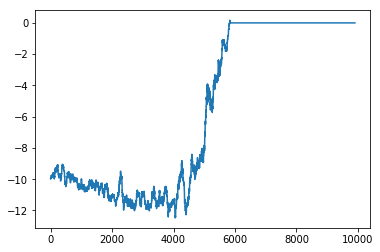

In [21]:
# For examining single agent performance
Q_table, final_episode, rewards_memory, Q_results_df, Q_avg_n_questions, Q_accuracy = train_evaluate_agent(
    n_episodes = 10000, alpha = .80, gamma = 0.95, eps_midpoint = 0.01, win_reward = 5, lose_reward = -10,
    turn_reward = -1, early_stopping_variance_threshold = 2, graph_performance = True)

print('Average Performance: {:.3} questions | Accuracy: {:.3} | Episode: {}'.format(Q_avg_n_questions, Q_accuracy,final_episode))
Q_results_df

In [22]:
def gridsearch(output_path = os.getcwd(), n_iterations=5):
    """Gridsearches specified parameters n times to test variability """
    param_grid = {'alpha': [0.95, 0.8, 0.5, 0.2, 0.05], 'gamma' : [0.95, 0.8, 0.50, 0.2, 0.05],
              'eps_midpoint' : [0.3, 0.2, 0.1, 0.05, 0.01]}

    grid = ParameterGrid(param_grid)

    # Determine the number of random configurations to test
    n_episodes = 20000
    grid = ParameterGrid(param_grid)
    configs = list(grid)

    # Randomly select subset
    #number_of_configs = 3
    #configs = np.random.choice(list(grid), replace=False, size=number_of_configs)
    
    for i in range(n_iterations):
        gridsearch_values = dict()

        # Reward Function
        win_reward = 5
        lose_reward = -10
        turn_reward = -1
        early_stopping_variance_threshold = 2

        print("Total number of possible configurations: {} |".format(len(grid)))

        for idx, param in enumerate(configs):

            print("--------------- Configuration {} ---------------".format(idx+1))
            Q_table, final_episode, rewards_memory, Q_results_df, Q_avg_n_questions, Q_accuracy = train_evaluate_agent(
            n_episodes, param['alpha'], param['gamma'], param['eps_midpoint'], win_reward, lose_reward,
            turn_reward, early_stopping_variance_threshold, graph_performance = False)

            gridsearch_values['config'+str(idx+1)] = {'results_df':Q_results_df, 'avg_questions':Q_avg_n_questions,
                                                     'accuracy':Q_accuracy,'final_episode': final_episode,
                                                      'stabilized_rewards': np.mean(rewards_memory), 'alpha':param['alpha'],
                                                      'gamma':param['gamma'], 'eps_midpoint':  param['eps_midpoint']}
        # Convert dictionary to dataframe
        gridsearch_df = pd.DataFrame.from_dict(gridsearch_values, orient = 'index')
        gridsearch_df.to_csv(os.path.join(output_path,'animal_farm_gridsearch'+str(i+1)+'.csv'),index=False)
        
    return list(grid), configs

In [23]:
def avg_files(input_path, file_name, features, num_rows):
    """Averages specified features across multiple saved output files"""
    gridsearch_files = [file for file in os.listdir(input_path) if file_name in file]
    average_performance = pd.DataFrame(np.zeros([num_rows,len(features)]),columns=features)

    for file in gridsearch_files:
        temp_file = pd.read_csv(os.path.join(input_path,file))
        average_performance += temp_file[features]

    average_performance /= len(gridsearch_files)

    row_labels = pd.read_csv(os.path.join(input_path,gridsearch_files[0])).drop(features,axis=1)
    average_performance = row_labels.join(average_performance)
    
    return average_performance

In [24]:
# Code which runs gridsearch then saves average model
# Please ensure that 'Model Outputs/' folder already exists in working directory

#grid, n_configs = gridsearch('Model_Outputs/', 3)
#avg_performance = avg_files('Model_Outputs_Binary/','animal_farm_gridsearch', ['avg_questions','accuracy','final_episode','stabilized_rewards'], 125)
#avg_performance.to_csv('average_performance.csv',index=False)

# Decision Tree Algorithm Performance

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Ignore deprecation warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Fit decision tree model
def fit_decision_tree():
    """Fits decision tree model for benchmarking against Q-learning agent"""
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(df['Animal'].copy())
    X = df[features[:-1]].copy()

    clf = DecisionTreeClassifier(random_state=34, criterion='entropy')
    clf.fit(X,y)
    predictions = le.inverse_transform(clf.predict(X))
    return X, clf, predictions

def query_decision_tree(animal_features, X, clf):
    """Searches decision tree to find the path a given animal takes given its features"""
    decision_path = clf.decision_path(animal_features).toarray()[0]
    split_features = [X.columns[clf.tree_.feature[i]] for i,j in enumerate(decision_path) if j == 1]
    # Exclude terminal node
    return split_features[:-1]

def train_evaluate_decision_tree():
    """Pipeline function which trains a decision tree and then evaluates its performance and returns the key metrics"""
    X, clf, predictions = fit_decision_tree()
    
    dt_results_df = pd.DataFrame({'Animal':df['Animal'].copy(),
                                  'DT_Nodes':[query_decision_tree([X.iloc[x].values], X, clf) for x in range(len(X))]}
                                ).reset_index(drop=True)

    dt_results_df['Predicted'] = np.where(predictions == dt_results_df['Animal'],'-',predictions)
    dt_results_df['N_Questions'] = [len(i) for i in dt_results_df['DT_Nodes']]

    dt_avg_n_questions = dt_results_df['N_Questions'].mean()
    dt_accuracy = 1-((dt_results_df['Predicted'] != '-').sum() / len(dt_results_df['Predicted']))

    return dt_results_df, dt_avg_n_questions, dt_accuracy

In [27]:
# Train decision tree and examine results
dt_results_df, dt_avg_n_questions, dt_accuracy = train_evaluate_decision_tree()

print('Average Performance: {:.3} questions | Accuracy: {:.3}'.format(dt_avg_n_questions, dt_accuracy))
dt_results_df

Average Performance: 4.42 questions | Accuracy: 1.0


,Animal,DT_Nodes,Predicted,N_Questions
0,aardvark,"[Predator, Aquatic, Backbone, Airborne, Eggs]",-,5
1,cavy,"[Predator, Airborne, Aquatic, Eggs]",-,4
2,chicken,"[Predator, Airborne, Backbone, Eggs, Aquatic]",-,5
3,clam,"[Predator, Aquatic, Backbone, Eggs, Airborne]",-,5
4,crab,"[Predator, Aquatic, Backbone, Nlegs_5]",-,4
5,dolphin,"[Predator, Aquatic, Backbone, Airborne, Eggs]",-,5
6,fruitbat,"[Predator, Airborne, Backbone, Eggs]",-,4
7,gull,"[Predator, Aquatic, Backbone, Airborne]",-,4
8,haddock,"[Predator, Airborne, Aquatic]",-,3
9,kiwi,"[Predator, Aquatic, Backbone, Airborne, Eggs]",-,5


# Outputs Graphs for Report

In [29]:
# Code to visualize decision tree path

"""from sklearn.tree import export_graphviz

# Visualize decision tree 
export_graphviz(clf, out_file='tree.dot', feature_names = X.columns,
                class_names = df['Animal'].values, rounded = True, proportion = False, precision = 2, filled = True)

#Can visualize at http://webgraphviz.com/"""

"from sklearn.tree import export_graphviz\n\n# Visualize decision tree \nexport_graphviz(clf, out_file='tree.dot', feature_names = X.columns,\n                class_names = df['Animal'].values, rounded = True, proportion = False, precision = 2, filled = True)\n\n#Can visualize at http://webgraphviz.com/"

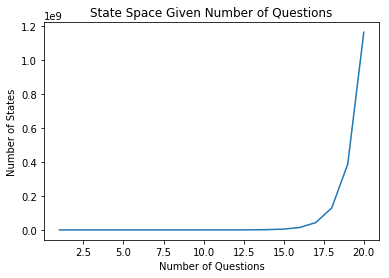

In [30]:
import seaborn as sns
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(sns.color_palette("RdYlBu"))

def visualize_transition_matrix(width, height, win_reward, lose_reward, turn_reward):
    """Visualizes the transition matrix in small environment. Not used in report"""
    state_space = len(features) * [-1]
    env = QuestionsGame(random.choice(animal), state_space, win_reward, lose_reward, turn_reward)

    state_matrix = pd.DataFrame(np.zeros([n_states, n_states]), columns=[coded_states.index.values])
    state_matrix[:] = np.nan

    for start_state in state_matrix.index:
        available_actions = [i for i in range(len(action_space)) if i not in np.argwhere(coded_states.values[start_state] != -1).flatten()]
        for action in available_actions:
            env.state = coded_states.loc[start_state].values.copy()
            end_state, reward, done = env.step(action)
            state_matrix.at[start_state,get_state_index(end_state)] = reward

    plt.figure(figsize=(width, height))
    plt.xlabel = ("asdas")

    ax1 = plt.axes()
    ax1.xaxis.label.set_visible(False)

    sns.heatmap(state_matrix, annot=False, cbar=False, cmap = ['r','b','g']);

#visualize_transition_matrix(15,8)

# Graph showing state space exploding - is exponential given permutations
illustrative_n_questions = 20
iteration_number = range(1,illustrative_n_questions+1)
illustrative_state_space = [3**i for i in range(illustrative_n_questions)]

plt.plot(iteration_number, illustrative_state_space);

plt.title('State Space Given Number of Questions');
plt.xlabel('Number of Questions');
plt.ylabel('Number of States');

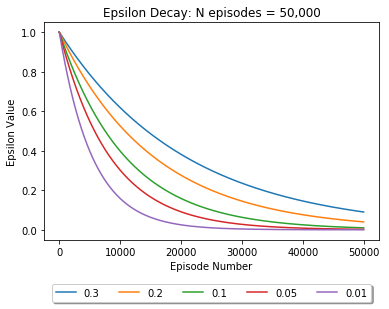

In [31]:
# Graph demonstrating the epsilon decline curves given different midpoints

n = 50000
desired_midpoint = [0.3, 0.2, 0.1, 0.05, 0.01]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

for eps_mid in desired_midpoint:
    ax1.plot([(eps_mid**(1/(n/2)))**(i) for i in range(n)], label = eps_mid)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=5);

plt.title('Epsilon Decay: N episodes = 50,000')
plt.xlabel('Episode Number');
plt.ylabel('Epsilon Value');

# Deep Q Network

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13260549433988443786
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6721677557
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1564510213784963552
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [33]:
# Define the Deep-Q Model
DQN_model = Sequential()
DQN_model.add(Dense(528,input_dim=len(features), activation='relu'))
DQN_model.add(Dense(256, activation='relu'))
DQN_model.add(Dense(len(action_space), activation='linear'))
DQN_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
DQN_model.summary()

# Define the target model for Double DQN
target_model = Sequential()
target_model.add(Dense(528,input_dim=len(features), activation='relu'))
target_model.add(Dense(256, activation='relu'))
target_model.add(Dense(len(action_space), activation='linear'))
target_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
target_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 528)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               135424    
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 146,073
Trainable params: 146,073
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 528)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               135424    
_________________________________________________________________
dens

In [ ]:
# Define state size and action size
state_size = len(features)
action_size = len(action_space)

# Define key model parameters
n_episodes = 25000
gamma = 0.95
epsilon = 1.0
eps_midpoint = 0.18
epsilon_decay = eps_midpoint**(1/(n_episodes/2))
min_epsilon = 0.10

# Define reward function
win_reward = 5
lose_reward = -10
turn_reward = -1

# Define memory for early stopping
rewards_memory = deque(maxlen=300)
early_stopping_variance_threshold = 3
avg_pred_rewards = 0

# Instantiate lists and define when to dump to txt to avoid memory overruns
max_question_count = 20
avg_reward_list = []
epsilon_list = []
export_to_txt = 1000

# Define memory for experience replay
state_action_memory = deque(maxlen=5000)
batch_size = 32
tau = 2500

for i in tnrange(1,n_episodes+1, desc='Deep Q Progress'):
    # Instantiate environment
    state_space = len(features) * [-1]
    env = QuestionsGame(random.choice(animal), state_space, win_reward, lose_reward, turn_reward)
    state = np.array(env.state).reshape([1,state_size])
    
    # Transfer weights to target model to improve stability
    if i % tau == 0:
        target_model.set_weights(DQN_model.get_weights())

    done = False
    reward_sum = 0
    question_count = 0
    
    # Decay memory once have enough memories to sample for experience replay
    if len(state_action_memory) == state_action_memory.maxlen:
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay

    # Early stopping if variance below threshold
    if len(rewards_memory) == rewards_memory.maxlen:
        avg_pred_rewards = np.mean(rewards_memory)
        if (np.var(rewards_memory) <= early_stopping_variance_threshold) & (avg_pred_rewards > lose_reward):
            break
            
    # Main Deep-Q Model loop
    while question_count <= max_question_count:     
        # Ensure agent cannot repeat actions
        available_actions = [i for i in range(len(action_space)) if i not in np.argwhere(state[0] != -1).flatten()]
        if np.random.rand() <= epsilon:
            action = np.random.choice(available_actions)
            early_stopping_gate=0
        else:
            act_values = DQN_model.predict(state)[0] # If not acting randomly, predict reward value based on current state
            q_values = [np.nan if i not in available_actions else x for i,x in enumerate(act_values)]
            max_val = np.nanmax(q_values)
            action = np.random.choice([idx for idx, val in enumerate(q_values) if val == max_val])
            early_stopping_gate=1
        
        # Transition to new state and reshape array
        new_state, reward, done = env.step(action)
        new_state = np.array(new_state).reshape([1,state_size])
        reward_sum += reward
        question_count += 1
        
        # Train neural netowork using DDQN and memory replay 
        state_action_memory.append((state, action, reward, new_state, done))
        if len(state_action_memory) > batch_size:
            minibatch = random.sample(state_action_memory, batch_size)
            for mem_state, mem_action, mem_reward, mem_new_state, mem_done in minibatch:
                if not mem_done:
                    target = (mem_reward + gamma * np.amax(target_model.predict(mem_new_state)))
                else:
                    target = mem_reward
                target_vec = target_model.predict(mem_state)[0]
                target_vec[mem_action] = target
                DQN_model.fit(mem_state, target_vec.reshape([1,action_size]), epochs=1, verbose=0)
        
        if early_stopping_gate & done:
            rewards_memory.append(reward_sum)
        
        if done == 1:
            break
        else:
            state = new_state
    
    avg_reward_list.append(reward_sum)
    epsilon_list.append(epsilon)
    
    # Export to text file at specified interval to monitor updating and avoid out of memory errors 
    if i % export_to_txt == 0:
        file = open('model_results.txt','a')
        np.savetxt(file, np.column_stack((np.arange(i-export_to_txt,i), avg_reward_list, epsilon_list)),
                   fmt= '%d %1.3f %1.3f')
        file.close()
        
        avg_reward_list.clear()
        epsilon_list.clear()
        
        #print("Episode {} of {}: score:{} epsilon:{:2}".format(i + 1, n_episodes, 
        #                                                       np.round(avg_pred_rewards,2), np.round(epsilon,4))

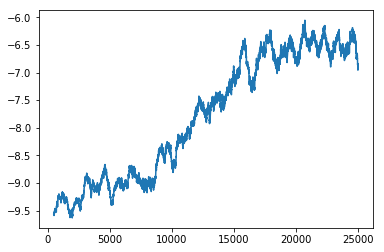

In [38]:
# Load model_results text file and load moving average chart
data = pd.read_csv('model_results.txt', sep=" ", header=None, names = ['episode','return','epsilon'],
                  dtype = {'episode':np.int,'return':np.float32,'epsilon':np.float32})

moving_average(data['return'],500);

In [296]:
max_question_count = 20

def query_deepQ(correct_animal = random.choice(animal), verbose=False, win_reward=5, lose_reward=-5, turn_reward=-1):
    """Runs a game on the trained model to see which questions are asked (no random actions)"""
    state_space = len(features) * [-1]
    env = QuestionsGame(correct_animal, state_space, win_reward, lose_reward, turn_reward)
    state = np.array(env.state).reshape([1,state_size])

    done = 0
    G = 0
    question_count = 1
    max_questions = 20
    Q_Nodes = []
    
    if verbose:
        print(env.correct_animal)
        print(action_space)
        
    while question_count <= max_question_count:
        available_actions = [i for i in range(len(action_space)) if i not in np.argwhere(state[0] != -1).flatten()]
        act_values = DQN_model.predict(state)[0] # if not acting randomly, predict reward value based on current state
        masked_act_values = [np.nan if i not in available_actions else x for i,x in enumerate(act_values)]
        
        if verbose:
            top_actions = np.argsort(-np.array(masked_act_values),kind='mergesort')[:3]
            Q_values = np.round(act_values[[top_actions]],2)
            actions = np.array(action_space)[[top_actions]]
            print("Question {}: ".format(question_count),[x for x in zip(Q_values,actions)])
        
        action = np.nanargmax(masked_act_values)
        Q_Nodes.append(action_space[action])
        
        next_state, reward, done = env.step(action)
        G += reward
        question_count += 1
        
        if done == 1:
            break
        else:
            state = np.array(next_state).reshape([1,state_size])
    
    if verbose:
        print("Total reward: ", G)
        
    return Q_Nodes
    
query_deepQ('swan',False,5,-10,-1)

['Predator', 'Eggs', 'Backbone', 'Nlegs_5', 'Airborne', 'Aquatic', 'fruitbat']

In [297]:
# Evaluate model performance and show key metrics. Not wrapped in function as was not grid-searched 
Q_results_df = pd.DataFrame({'Animal':df['Animal'].copy(),
                              'Q_Nodes':[query_deepQ(animal,False,5,-10,-1) for animal in df['Animal']]}).reset_index(drop=True)
predictions = [x[-1] for x in Q_results_df['Q_Nodes']]
Q_results_df['Predicted'] = np.where(predictions == Q_results_df['Animal'],'-',predictions)
Q_results_df['Q_Nodes'] = [x[:-1] for x in Q_results_df['Q_Nodes']]
Q_results_df['N_Questions'] = [len(i) for i in Q_results_df['Q_Nodes']]

Q_avg_n_questions = Q_results_df['N_Questions'].mean()
Q_accuracy = 1-((Q_results_df['Predicted'] != '-').sum() / len(Q_results_df['Predicted']))

print('Average Performance: {:.3} questions | Accuracy: {:.3}'.format(Q_avg_n_questions, Q_accuracy))

Q_results_df

Average Performance: 5.58 questions | Accuracy: 0.263


,Animal,Q_Nodes,Predicted,N_Questions
0,aardvark,"[Predator, Eggs, Airborne, Backbone, Aquatic, ...",cavy,6
1,cavy,"[Predator, Eggs, Backbone, Airborne]",-,4
2,chicken,"[Predator, Eggs, Backbone, Nlegs_5, Airborne, ...",scorpion,6
3,clam,"[Predator, Eggs, Backbone, Airborne, Nlegs_5, ...",cavy,6
4,crab,"[Predator, Eggs, Backbone, Airborne, Nlegs_5, ...",scorpion,6
5,dolphin,"[Predator, Eggs, Airborne, Backbone, Aquatic, ...",-,6
6,fruitbat,"[Predator, Eggs, Backbone, Airborne]",-,4
7,gull,"[Predator, Eggs, Backbone, Airborne, Aquatic, ...",fruitbat,6
8,haddock,"[Predator, Eggs, Backbone, Nlegs_5, Airborne, ...",cavy,6
9,kiwi,"[Predator, Eggs, Backbone, Airborne, Aquatic, ...",scorpion,6


In [34]:
# Save model weights 
#model.save_weights('two_layers_64_6Q_10.h5')

# Bayesian Environment w/ Deep-Q Agent

In [35]:
# Load animal characteristic information
df = pd.read_csv('knowledge_base.csv')   # Source: https://github.com/earthtojake/20q

# Define possible animals
state_space = ['swan','dolphin','fruitbat','cavy','aardvark','chicken','clam','crab','gull','haddock',
                 'kiwi','ladybird','ostrich','penguin','scorpion','vulture','wasp','worm','starfish','game_state']

# Define possible features
action_space = ['Aquatic','Airborne','Predator','Eggs','Backbone','Nlegs_5','Animal']

df = df[action_space].loc[df['Animal'].isin(state_space[:-1])]
action_space[-1] = 'Prediction'

# Refine guess formula for bayesian environment
def make_guess(correct_animal, state):
    predicted_animal = state_space[np.random.choice(np.flatnonzero(state == state.max()))]
    if correct_animal == predicted_animal:
        return 1
    else:
        return 0

In [36]:
class BayesianQuestionsGame(gym.Env):
    """Define bayesian 20 Questions environment"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, correct_animal, state_space, action_space):
        self.correct_animal = correct_animal
        self.state_space = state_space
        self.action_space = action_space
        inst_state = -np.ones(len(self.state_space),dtype='float32')
        inst_state[:-1] = [1/len(inst_state[:-1])]*len(inst_state[:-1])
        self.state = inst_state
        self.reward = 0
        self.episode_over = 0
        self.question_number = 0
        self.question_discount = 0.7
    
    def step(self, action):
        assert 0 <= action <= len(self.action_space)-1, 'Please select an action from the action space'
        self.question_number += 1
        
        if action == len(self.action_space)-1:
            self.state[-1] = make_guess(self.correct_animal, self.state)
            self.episode_over = 1
            if self.state[-1] == 1:
                self.reward = 5 #np.round(50*(self.question_discount)**self.question_number,2)
            else:
                self.reward = -10
        else:
            self.state[:-1] = posterior(self.correct_animal,self.action_space[action],self.state[:-1])
            self.reward = -1
            
        return self.state, self.reward, self.episode_over
    
    def reset(self):
        inst_state = -np.ones(len(self.state_space),dtype='float32')
        inst_state[:-1] = [1/len(inst_state[:-1])]*len(inst_state[:-1])
        self.state = inst_state
        self.reward = 0
        self.episode_over = 0
        
    def render(self, mode='human', close=False):
        print(self.state)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2930543872218103098
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6721677557
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18115238815528647536
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [38]:
env = BayesianQuestionsGame('bass',state_space,action_space)

# Define the DQN model
DQN_model = Sequential()
DQN_model.add(Dense(100,input_dim=len(env.state_space), activation='relu'))
DQN_model.add(Dense(100, activation='relu'))
DQN_model.add(Dense(len(env.action_space), activation='linear'))
DQN_model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
DQN_model.summary()

# Define the target model for Double DQN
target_model = Sequential()
target_model.add(Dense(100,input_dim=len(env.state_space), activation='relu'))
target_model.add(Dense(100, activation='relu'))
target_model.add(Dense(len(env.action_space), activation='linear'))
target_model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
target_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 707       
Total params: 12,907
Trainable params: 12,907
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_

In [ ]:
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import deque

# Define key model parameters
num_episodes = 50000
y = 0.95
eps = 1.0

eps_midpoint = 0.10
decay_factor = eps_midpoint**(1/(num_episodes/2))
min_epsilon = 0.10

# Instantiate lists and define when to dump to txt to avoid memory overruns
max_question_count = 20
r_avg_list = []
eps_list = []
export_to_txt = 1000

# Define memory for early stopping
rewards_memory = deque(maxlen=300)
early_stopping_variance_threshold = 2
avg_pred_rewards = 0

# Define memory for experience replay
state_action_memory = deque(maxlen=5000)
batch_size = 32
tau = 2500

for i in tnrange(1,num_episodes+1, desc='Deep Q Progress'):
    # Instantiate environment
    env = BayesianQuestionsGame(random.choice(state_space[:-1]), state_space, action_space)
    available_actions = -np.ones(len(env.action_space),dtype='float32')
    s = env.state.reshape([1,len(env.state_space)])
    
    # Transfer weights to target model to improve stability
    if i % tau == 0:
        target_model.set_weights(DQN_model.get_weights())
    
    done = False
    r_sum = 0
    question_count = 0
    
    # Decay memory once have enough memories to sample for experience replay
    if len(state_action_memory) == state_action_memory.maxlen:
        if eps > min_epsilon:
            eps *= decay_factor
    
    # Early stopping if variance below threshold
    if len(rewards_memory) == rewards_memory.maxlen:
        avg_pred_rewards = np.mean(rewards_memory)
        if (np.var(rewards_memory) <= early_stopping_variance_threshold) & (avg_pred_rewards > -10):
            break
    
    # Main Deep-Q Model loop
    while question_count <= max_question_count:
        # Ensure agent cannot repeat actions
        available_actions_idx = np.argwhere(available_actions == -1).flatten()
        
        # Force agent to make guess if prob of any animal is equal to one
        if max(env.state) == 1:
            a = len(env.action_space)-1
        
        elif np.random.rand() <= eps:
            a = np.random.choice(available_actions_idx)
            
        else:
            act_values = DQN_model.predict(s)[0] # If not acting randomly, predict reward value based on current state
            q_values = [np.nan if i not in available_actions_idx else x for i,x in enumerate(act_values)]
            max_val = np.nanmax(q_values)
            a = np.random.choice([idx for idx, val in enumerate(q_values) if val == max_val])
        
        # Transition to new state and reshape array
        new_s, r, done = env.step(a)
        new_s = new_s.reshape([1,len(env.state_space)])
        
        available_actions[a] = 0
        r_sum += r
        question_count += 1
        
        # Train neural netowork using DDQN and memory replay
        state_action_memory.append((s, a, r, new_s, done))
        if len(state_action_memory) > batch_size:
            minibatch = random.sample(state_action_memory, batch_size)
            for mem_s, mem_a, mem_r, mem_new_s, mem_done in minibatch:
                if not mem_done:
                    target = mem_r + y * np.max(target_model.predict(mem_new_s))
                else:
                    target = mem_r
                target_vec = target_model.predict(mem_s)[0]
                target_vec[mem_a] = target
                DQN_model.fit(mem_s, target_vec.reshape([1,len(env.action_space)]), epochs=1, verbose=0)

        if done == 1:
            break
        else:
            s = new_s
    
    r_avg_list.append(r_sum)
    eps_list.append(eps) 
    
    # Export to text file at specified interval to monitor updating and avoid out of memory errors
    if i % export_to_txt == 0:
        file = open('bayes_model_results.txt','a')
        np.savetxt(file, np.column_stack((np.arange(i-export_to_txt,i), r_avg_list, eps_list)),
                   fmt= '%d %1.3f %1.3f')
        file.close()
        
        r_avg_list.clear()
        eps_list.clear()

In [ ]:
# Load model_results text file and load moving average chart
data = pd.read_csv('bayes_model_results.txt', sep=" ", header=None, names = ['episode','return','epsilon'],
                  dtype = {'episode':np.int,'return':np.float32,'epsilon':np.float32})
moving_average(data['return'],150);

In [ ]:
def query_bayesianQ(correct_animal = random.choice(state_space[:-1]), verbose=False):
    """Runs a game on the trained model to see which questions are asked (no random actions)"""
    env = BayesianQuestionsGame(correct_animal, state_space,action_space)
    available_actions = -np.ones(len(env.action_space),dtype='float32')
    state = env.state.reshape([1,len(env.state_space)])

    done = 0
    G = 0
    question_count = 1
    max_questions = 20
    Q_Nodes = []
    
    if verbose:
        print(env.correct_animal)
        print(env.action_space)
    
    while question_count <= max_question_count:
        if max(env.state) == 1:
            action = len(env.action_space)-1
        else:
            available_actions_idx = np.argwhere(available_actions == -1).flatten()
            act_values = DQN_model.predict(state)[0] # if not acting randomly, predict reward value based on current state
            action = np.nanargmax([np.nan if i not in available_actions_idx else x for i,x in enumerate(act_values)])
        
        next_state, reward, done = env.step(action)
        
        available_actions[action] = 1
        G += reward
        question_count += 1
        
        if done == 1:
            Q_Nodes.append(state_space[np.random.choice(np.flatnonzero(state[0][:-1] == state[0][:-1].max()))])
            break
        else:
            Q_Nodes.append(action_space[action])
            state = next_state.reshape([1,len(env.state_space)])
    
    if verbose:
        print("Total reward: ", G)
        
    return Q_Nodes
    
query_bayesianQ('swan',False)

In [ ]:
# Evaluate model performance and show key metrics. Not wrapped in function as was not grid-searched 
Q_results_df = pd.DataFrame({'Animal':df['Animal'].copy(),
                              'Q_Nodes':[query_bayesianQ(animal) for animal in df['Animal']]}).reset_index(drop=True)
predictions = [x[-1] for x in Q_results_df['Q_Nodes']]
Q_results_df['Predicted'] = np.where(predictions == Q_results_df['Animal'],'-',predictions)
Q_results_df['Q_Nodes'] = [x[:-1] for x in Q_results_df['Q_Nodes']]
Q_results_df['N_Questions'] = [len(i) for i in Q_results_df['Q_Nodes']]

Q_avg_n_questions = Q_results_df['N_Questions'].mean()
Q_accuracy = 1-((Q_results_df['Predicted'] != '-').sum() / len(Q_results_df['Predicted']))

print('Average Performance: {:.3} questions | Accuracy: {:.3}'.format(Q_avg_n_questions, Q_accuracy))

Q_results_df